### Johdanto datatieteeseen
# Tampereen kaksiot
## Tuomas Mäkäräinen, 274351

In [135]:
from bs4 import BeautifulSoup as bs
from requests import get
import pandas as pd
import numpy as np
import time, os
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline

print('Done importing')

Done importing


In [142]:
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

In [3]:
houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])

In [154]:

if fileName in os.listdir('./data/'):
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481187938&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
        #temp = houseCards[0]
            spans = temp.find_all('span', class_='')
            """ price = spans[5].contents[0].replace('\xa0', '')[:-1] # Hinta
            size = spans[7].contents[0] # Koko
            year = spans[10].contents[0] # Vuosi """

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area)
            data['Osoite'].append(address)
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type)
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'))
    df = pd.DataFrame(data)
    df.to_csv('./data/tampere_kaksiot_etuovi.csv')
    print('Done scraping')

Local data found! Imported to DataFrame.


In [90]:
df.head()

,Alue,Osoite,Hinta,Koko,Vuosi,Talotyyppi,Sauna,Parveke
0,Tesoma,Virontörmänkatu 10,96000.0,55.5,1970.0,Kerrostalo,False,True
1,Villilä,Ratakistonkatu 29,188000.0,62.0,2007.0,Rivitalo,True,False
2,Irjala,Kolarinkatu 21,139000.0,54.5,1973.0,Kerrostalo,False,False
3,Järvensivu,Järvensivuntie 13,199000.0,50.5,2006.0,Kerrostalo,True,False
4,Hervanta,Opinpolku 1,105000.0,46.5,1984.0,Kerrostalo,True,False


In [118]:
df.describe()

,Hinta,Koko,Vuosi
count,880.000000,880.000000,880.000000
mean,207740.162500,47.448864,2008.393182
std,71011.577061,8.689365,22.718387
min,57000.000000,29.000000,1920.000000
25%,153640.000000,40.500000,2011.000000
50%,199000.000000,47.000000,2020.000000
75%,245037.500000,54.000000,2021.000000
max,399980.000000,89.000000,2022.000000


In [155]:
df.dropna(inplace=True, axis=0)

""" indexes = df[df['Hinta'] < 50000].index
df.drop(indexes, inplace=True)

indexes = df[df['Hinta'] > 400000].index
df.drop(indexes, inplace=True) """

df.reset_index(drop=True, inplace=True)
df['Hinta'] = df['Hinta'].astype('int64')
df.describe()

,Hinta,Koko,Vuosi
count,909.000000,909.000000,909.000000
mean,214774.568757,48.036304,2008.643564
std,84679.378011,9.358973,22.546929
min,0.000000,29.000000,1920.000000
25%,155000.000000,40.500000,2012.000000
50%,199900.000000,47.500000,2020.000000
75%,251800.000000,54.500000,2021.000000
max,708550.000000,93.500000,2022.000000


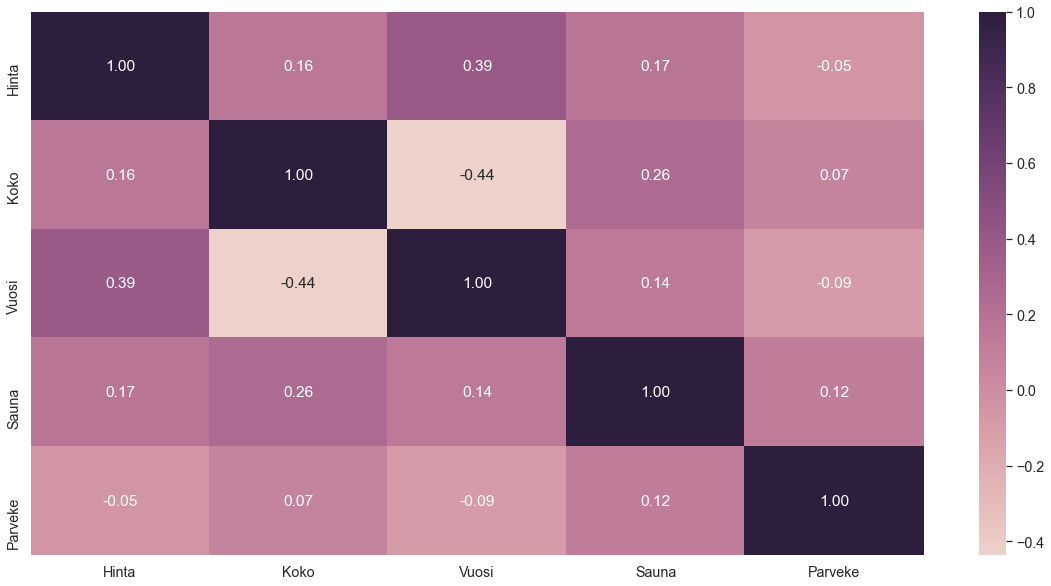

In [148]:
cmap = sb.cubehelix_palette(as_cmap=True)
color = sb.cubehelix_palette()

sb.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(correlation_df,annot=True,fmt='.2f',cmap=cmap)

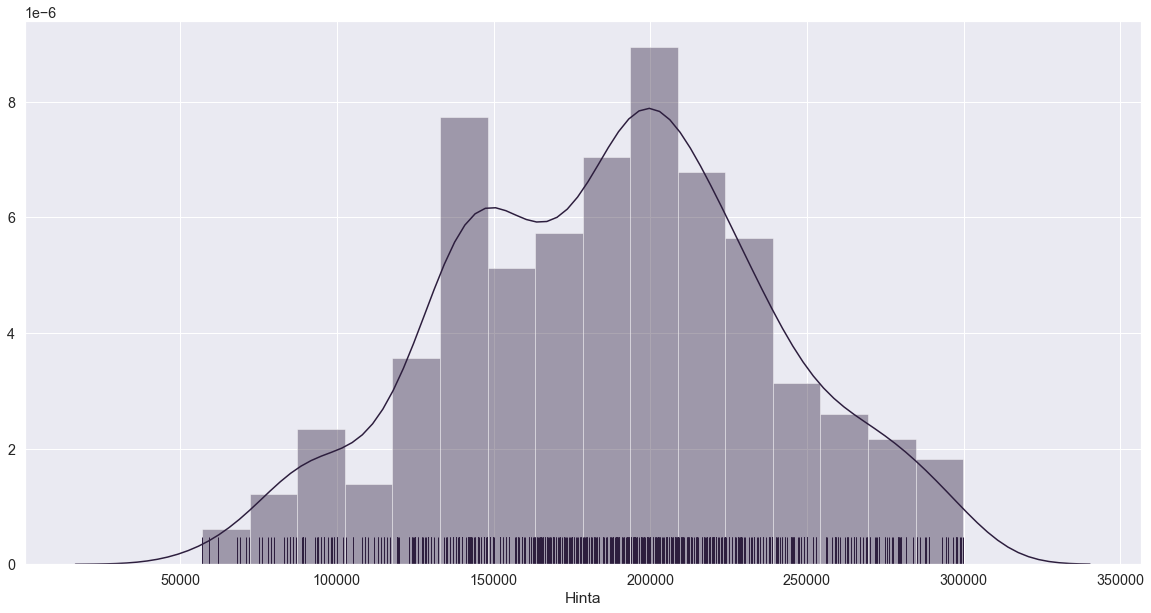

In [121]:
plt.figure(figsize=(20,10))
sb.distplot(df['Hinta'], color=color[5], rug=True)

In [149]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_cols.append(key)
important_cols

['Vuosi', 'Sauna', 'Koko']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 <a list of 84 Text major ticklabel objects>)

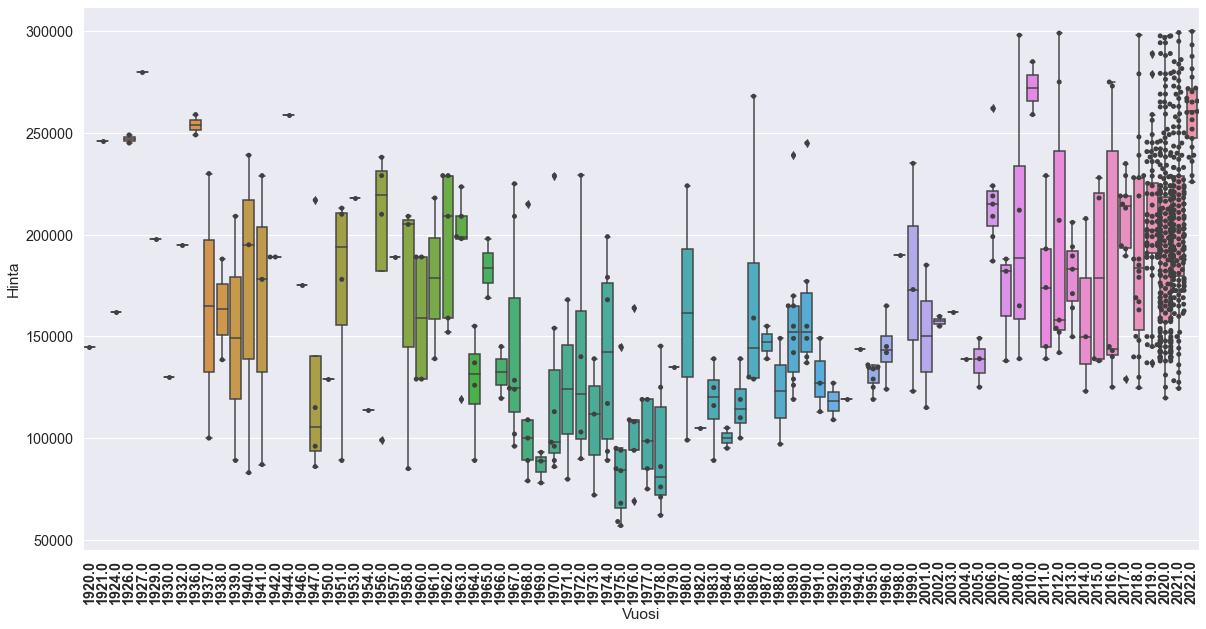

In [123]:
plt.figure(figsize=(20,10))
sb.boxplot(x='Vuosi', y="Hinta", data=df)
sb.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25")

plt.xticks(weight='bold',rotation=90)


In [150]:
y = df[['Hinta']]
X = df[important_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(660, 3) (660, 1) (220, 3) (220, 1)


In [151]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [152]:
y_train_result = lm.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_train_result))
r2 = r2_score(y_train, y_train_result)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_result = lm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_result))
r2 = r2_score(y_test, y_test_result)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 59749.01964783644
R2 score is 0.26977903580220575


The model performance for testing set
--------------------------------------
RMSE is 61812.87728292929
R2 score is 0.2966093873105208


In [ ]:
train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

In [ ]:
correlation_train=train.corr()
plt.figure(figsize=(5,20))
sb.heatmap(correlation_train[['Hinta']].sort_values(by=['Hinta'],ascending=False).head(60),vmin=-1, cmap=cmap, annot=True)

In [ ]:
plt.figure(figsize=(25,10))
train.boxplot(column=important_cols)
plt.xticks(weight='bold',rotation=90)

In [ ]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(important_cols))]
for i,c in zip(important_cols,colors):
    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(15,10))
    #plt.scatter(x=train[i], y=train["SalePrice"],c=c,alpha=0.7)
    sb.jointplot(x=i, y="Hinta", data=train, kind="reg",color=c)
    #sb.regplot(x=train[i], y=train["SalePrice"], color=c,fit_reg=True,marker='o',scatter_kws={'s':50})
    plt.xlabel(str(i))
    plt.yticks(np.arange(0,800001,50000))

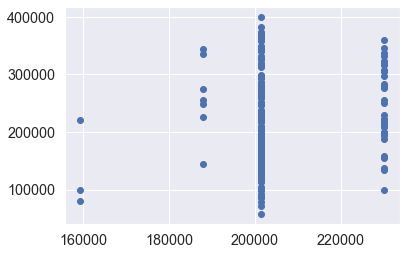

In [114]:
plt.scatter(y_test_result, y_test)

In [174]:
huber = HuberRegressor(epsilon=10).fit(X_train, y_train)
y_test_result = huber.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_result))
r2 = r2_score(y_test, y_test_result)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 61811.72729462125
R2 score is 0.29663555931518026


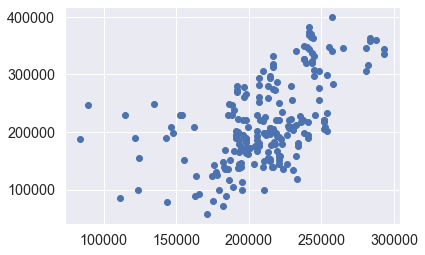

In [175]:
plt.scatter(y_test_result, y_test)